In [ ]:
#   /content/drive/MyDrive/Data_science/animals10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image

import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classes_latin = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno":"spider", "squirrel": "scoiattolo"}
classes = [translate[class_name] for class_name in classes_latin]

In [ ]:
classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [ ]:
X = np.load('/content/drive/MyDrive/Data_science/animals10/X_numpy.npy', allow_pickle=True)
y = np.load('/content/drive/MyDrive/Data_science/animals10/y_numpy.npy', allow_pickle=True)

In [ ]:
X.shape

(26179, 224, 224, 3)

In [ ]:
X_pre = np.empty_like(X)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

for i in range(0, X.shape[0]):
  x_temp = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
  X_pre[i,:,:,:] = preprocess_input(x_temp)

In [ ]:
y_cat = keras.utils.to_categorical(y, num_classes=10)

In [ ]:
del X
del y


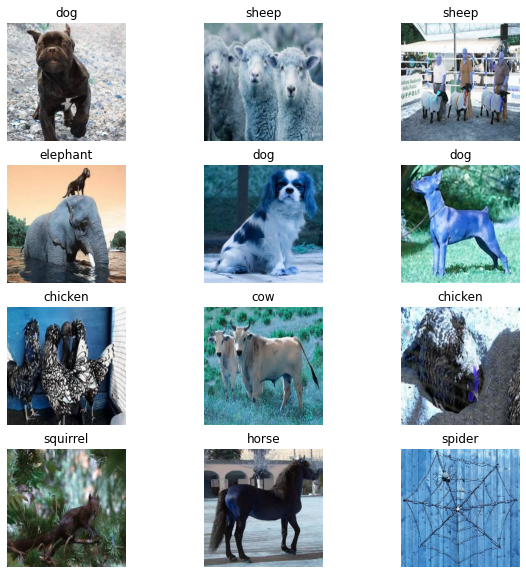

In [ ]:
plt.figure(figsize=(10, 10))
id_images_to_show = np.random.choice(np.arange(len(X_pre)), 12, replace=False)
for i in range(len(id_images_to_show)):
  idx = [id_images_to_show[i]]
  ax = plt.subplot(4, 3, i+1)
  plt.imshow(X[idx][0])
  plt.title(classes[int(y[idx])])
  plt.axis("off")

In [ ]:
vgg16_test = VGG16(weights="imagenet", include_top=True, input_shape=(224,224,3))


553476096/553467096 [==============================] - 4s 0us/step


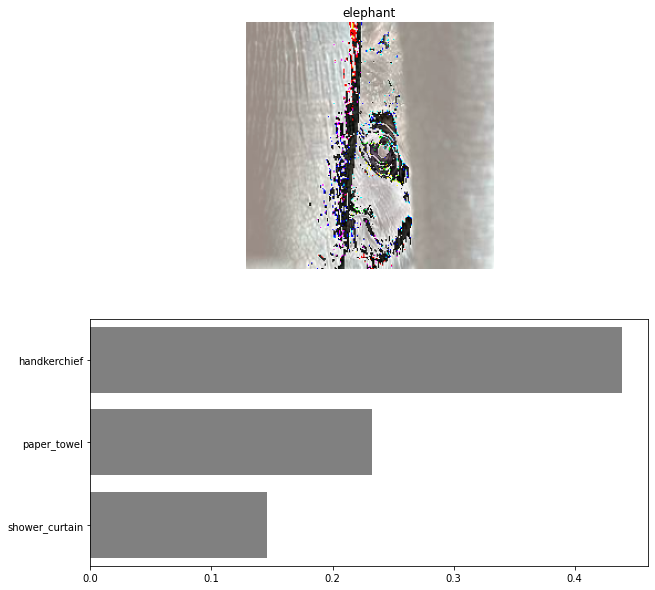

In [ ]:
id = 7500
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
plt.imshow(X_pre[id])
plt.title(classes[int(y[id])])
plt.axis("off")


preds  = decode_predictions(vgg16_test.predict(X_pre[id:id+1]), top=3)

ax = plt.subplot(2, 1, 2)
b = sns.barplot(y=[c[1] for c in preds[0]], x=[c[2] for c in preds[0]], color="gray")

Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pre, y_cat, test_size=0.15, random_state=43)

In [ ]:
del X_pre


Transfer Learning

In [ ]:
base_model = VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
base_model.trainable = False
# keras.utils.plot_model(base_model, "convolotions.png", show_shapes=True)

In [ ]:
flatten = keras.layers.Flatten()(base_model.output)
dropout1 = keras.layers.Dropout(0.1)(flatten)
dense1 = keras.layers.Dense(500, activation='relu')(dropout1)
dropout2 = keras.layers.Dropout(0.1)(dense1)
dense2 = keras.layers.Dense(250, activation='relu')(dropout2)
dropout3 = keras.layers.Dropout(0.1)(dense2)
prediction_layer = keras.layers.Dense(10, activation='softmax')(dropout3)

model = keras.Model(base_model.input, prediction_layer, name="tl-model")
model.summary()

Model: "tl-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import time 
from tensorflow.keras.callbacks import ModelCheckpoint

start = time.time()
train_history = model.fit(x=X_train,
        y=y_train,
        batch_size=32,
        epochs=15,
        validation_split=0.15,
        shuffle=True,
        callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr],)
end = time.time()
run_time = end - start

Epoch 1/15
592/592 [==============================] - 220s 370ms/step - loss: 4.1747 - accuracy: 0.4769 - val_loss: 1.4414 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 2/15
592/592 [==============================] - 213s 360ms/step - loss: 1.4432 - accuracy: 0.5786 - val_loss: 1.3919 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 3/15
592/592 [==============================] - 213s 359ms/step - loss: 1.2868 - accuracy: 0.6375 - val_loss: 1.2935 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 4/15
592/592 [==============================] - 213s 360ms/step - loss: 1.0828 - accuracy: 0.6797 - val_loss: 1.0830 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 5/15
592/592 [==============================] - 213s 360ms/step - loss: 0.9541 - accuracy: 0.7086 - val_loss: 1.0475 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 6/15
592/592 [==============================] - 213s 360ms/step - loss: 0.8286 - accuracy: 0.7357 - val_loss: 1.0376 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 7/15
592/592 [==========================

In [ ]:
model.save('/content/drive/MyDrive/Data_science/animals10/two-layer-try2-best')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data_science/animals10/two-layer-try2-best/assets


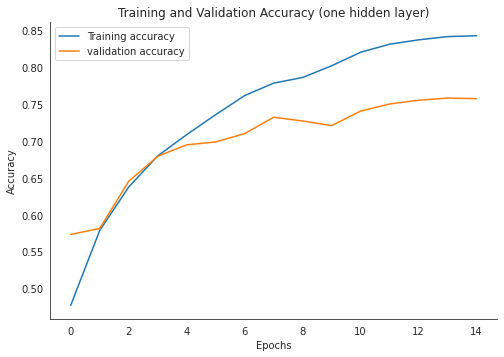

In [ ]:
plt.figure(figsize=(8, 12))
epochs = 15
sns.set_style("white")
plt.subplot(2, 1, 1)
plt.plot(range(0,epochs), train_history.history['accuracy'][:epochs], label='Training accuracy')
plt.plot(range(0,epochs), train_history.history['val_accuracy'][:epochs], label='validation accuracy')
plt.title('Training and Validation Accuracy (one hidden layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
sns.despine()
plt.savefig('accuracy' + '.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bast'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'bast'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


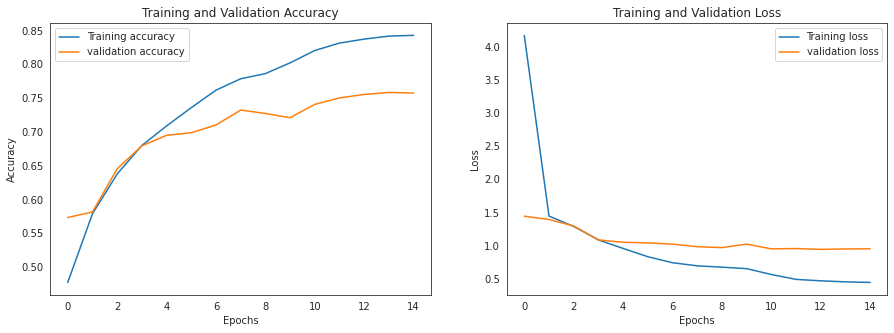

In [ ]:


fig, axs = plt.subplots(1,2,figsize = (15,5))

axs[0].plot(range(0,len(train_history.history['accuracy'])),train_history.history['accuracy'])
axs[0].plot(range(0,len(train_history.history['val_accuracy'])),train_history.history['val_accuracy'])
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Training accuracy','validation accuracy'])
axs[1].plot(range(0,len(train_history.history['loss'])),train_history.history['loss'])
axs[1].plot(range(0,len(train_history.history['val_loss'])),train_history.history['val_loss'])
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Training loss','validation loss'])

plt.show()

In [ ]:
y_test_predicted = model.predict(X_test)
test_history = model.evaluate(X_test, y_test, return_dict=True)

123/123 [==============================] - 37s 301ms/step - loss: 0.9207 - accuracy: 0.7538


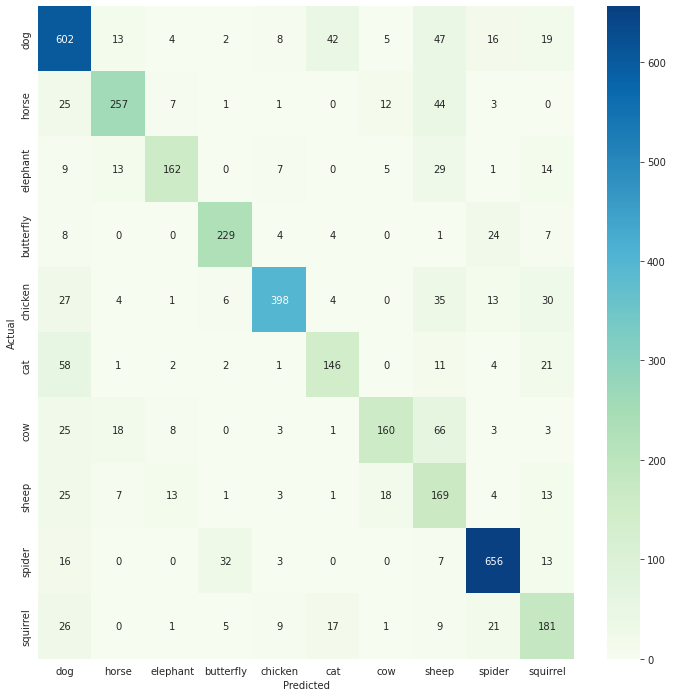

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(1), y_test_predicted.argmax(1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap="GnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
output_table = dict(epochs=[], first_layer_neuron=[], second_layer_neuron=[], batch_size=[], accuracy=[], loss=[], run_time=run_time)

model_config = dict(epochs=[15], first_layer_neuron=[500], second_layer_neuron=[250], batch_size=[32])

for keys in model_config.keys():  
  output_table[keys].append(model_config[keys][0])

for keys in test_history.keys():  
  output_table[keys].append(test_history[keys])



df = pd.DataFrame(output_table)
df.to_csv(r'truth_table.csv', index=False)

In [ ]:
output_table


{3206.046872615814: 3206.046872615814,
 'accuracy': [0.753756046295166],
 'batch_size': [32],
 'epochs': [15],
 'first_layer_neuron': [500],
 'loss': [0.9206904172897339],
 'run_time': [],
 'second_layer_neuron': [250]}

Fine tuning

In [ ]:
base_model.trainable = True

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy']) #using smaller learning rate

In [ ]:
import time 
from tensorflow.keras.callbacks import ModelCheckpoint

start = time.time()
train_history = model.fit(x=X_train,
        y=y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.15,
        shuffle=True,
        callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr],)
end = time.time()
run_time = end - start

Epoch 1/10
592/592 [==============================] - 580s 969ms/step - loss: 0.5349 - accuracy: 0.8221 - val_loss: 0.8324 - val_accuracy: 0.7753 - lr: 1.0000e-05
Epoch 2/10
592/592 [==============================] - 559s 945ms/step - loss: 0.4779 - accuracy: 0.8393 - val_loss: 0.7954 - val_accuracy: 0.7825 - lr: 1.0000e-05
Epoch 3/10
592/592 [==============================] - 562s 950ms/step - loss: 0.4468 - accuracy: 0.8497 - val_loss: 0.7440 - val_accuracy: 0.8092 - lr: 1.0000e-05
Epoch 4/10
592/592 [==============================] - 560s 946ms/step - loss: 0.4220 - accuracy: 0.8606 - val_loss: 0.7316 - val_accuracy: 0.7999 - lr: 1.0000e-05
Epoch 5/10
592/592 [==============================] - 559s 944ms/step - loss: 0.3892 - accuracy: 0.8723 - val_loss: 0.6660 - val_accuracy: 0.8170 - lr: 1.0000e-05
Epoch 6/10
592/592 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8822INFO:tensorflow:Assets written to: VGG16.model/assets

Epoch 6: ReduceLROnPlateau reducing

# Loading model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Data_science/animals10/two-layer-try2-best')

In [ ]:
loaded_model.summary()

Model: "tl-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
for layer in loaded_model.layers:
    layer.trainable = True

In [ ]:
loaded_model.summary()

Model: "tl-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy']) #using smaller learning rate

In [ ]:
import time 
from tensorflow.keras.callbacks import ModelCheckpoint

start = time.time()
train_history = loaded_model.fit(x=X_train,
        y=y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.15,
        shuffle=True,
        callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr],)
end = time.time()
run_time = end - start

Epoch 1/10
592/592 [==============================] - 310s 495ms/step - loss: 0.5480 - accuracy: 0.8179 - val_loss: 0.8744 - val_accuracy: 0.7546 - lr: 1.0000e-05
Epoch 2/10
592/592 [==============================] - 289s 489ms/step - loss: 0.5145 - accuracy: 0.8323 - val_loss: 0.7942 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 3/10
592/592 [==============================] - 290s 490ms/step - loss: 0.4423 - accuracy: 0.8541 - val_loss: 0.7500 - val_accuracy: 0.7885 - lr: 1.0000e-05
Epoch 4/10
592/592 [==============================] - 289s 488ms/step - loss: 0.4209 - accuracy: 0.8606 - val_loss: 0.7120 - val_accuracy: 0.8005 - lr: 1.0000e-05
Epoch 5/10
592/592 [==============================] - 289s 488ms/step - loss: 0.3646 - accuracy: 0.8762 - val_loss: 0.6863 - val_accuracy: 0.8032 - lr: 1.0000e-05
Epoch 6/10
592/592 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8817INFO:tensorflow:Assets written to: VGG16.model/assets

Epoch 6: ReduceLROnPlateau reducing

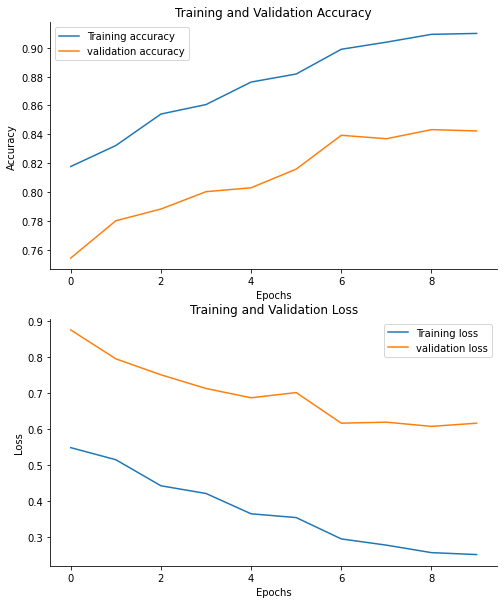

In [ ]:
fig, axs = plt.subplots(2,1,figsize = (8,10))

axs[0].plot(range(0,len(train_history.history['accuracy'])),train_history.history['accuracy'])
axs[0].plot(range(0,len(train_history.history['val_accuracy'])),train_history.history['val_accuracy'])
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Training accuracy','validation accuracy'])
axs[1].plot(range(0,len(train_history.history['loss'])),train_history.history['loss'])
axs[1].plot(range(0,len(train_history.history['val_loss'])),train_history.history['val_loss'])
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Training loss','validation loss'])
sns.despine()
plt.show()

In [ ]:
y_test_predicted = loaded_model.predict(X_test)
test_history = loaded_model.evaluate(X_test, y_test, return_dict=True)

123/123 [==============================] - 18s 149ms/step - loss: 0.6415 - accuracy: 0.8373


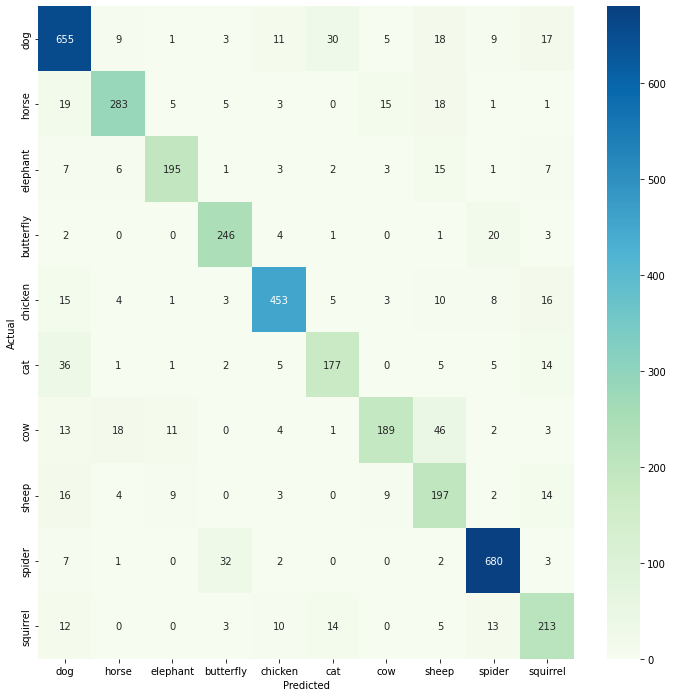

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(1), y_test_predicted.argmax(1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap="GnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
output_table = dict(epochs=[], first_layer_neuron=[], second_layer_neuron=[], batch_size=[], accuracy=[], loss=[], run_time=run_time)

model_config = dict(epochs=[15], first_layer_neuron=[500], second_layer_neuron=[250], batch_size=[32])

for keys in model_config.keys():  
  output_table[keys].append(model_config[keys][0])

for keys in test_history.keys():  
  output_table[keys].append(test_history[keys])



df = pd.DataFrame(output_table)
df.to_csv(r'truth_table_fine_tune.csv', index=False)

In [ ]:
loaded_model.save('/content/drive/MyDrive/Data_science/animals10/two-layer-try2-best-')